In [1]:
import os
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
VALIDATION_SIZE = 0.15
TRAIN_BATCHSIZE = 32
TEST_BATCHSIZE = 64
TRAIN_EPOCHS = 5
DATA_PATH = 'dataset/'
IMG_SHAPE = (96,96)

# Data first look

In [4]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'training.csv'))
train_df.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [6]:
train_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [15]:
len(train_df['Image'][0])

33593

In [137]:
def get_np_imgs(str_imgs):
    np_imgs = []
    for sample_img in str_imgs:
        arr = sample_img.split(' ')
        np_arr = np.array(arr, dtype= np.int32)
        np_img = np_arr.reshape(96,96)
        np_img = np_img / 255
        np_imgs.append(np_img)
    return np_imgs

In [138]:
def get_keypoints(keyponits):
    keyponits = keyponits.drop(columns = ['Image'], axis= 1)
    keypoint_features = []
    for _, sample_keypoints in keyponits.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

In [174]:
def show_img_with_keypoints(img, keypoints, title, ax):
    #fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.scatter(keypoints[0::2], keypoints[1::2], marker='x', s=20, c= 'r')
    ax.set_title(f"{title}")
    #plt.title()
    return

In [157]:
%%time

np_imgs = get_np_imgs(train_df['Image'])
keypoints = get_keypoints(train_df)

CPU times: total: 8.67 s
Wall time: 8.66 s


In [168]:
len(np_imgs)

7049

In [169]:
keypoints.shape

(7049, 30)

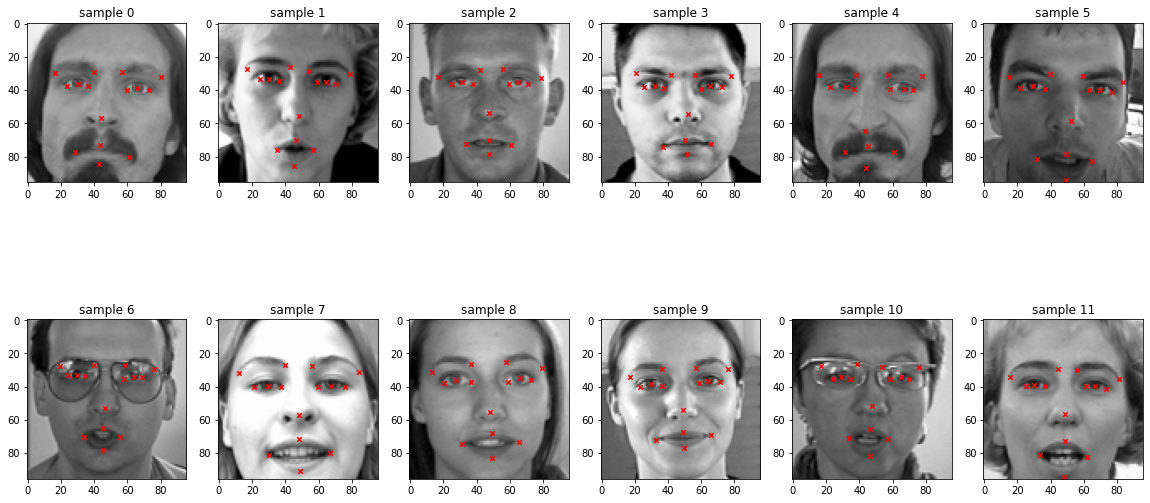

In [188]:
fig, axs = plt.subplots(2,6, figsize= (20,10))


for i in range(0,12):
    if i >= 6:
        cnt = i - 6
        show_img_with_keypoints(np_imgs[i], keypoints[i], f'sample {i}', ax= axs[1][cnt])
    else:
        show_img_with_keypoints(np_imgs[i], keypoints[i], f'sample {i}', ax= axs[0][i])


In [14]:
idlookup_data = pd.read_csv(os.path.join(DATA_PATH, 'IdLookupTable.csv'))
idlookup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RowId        27124 non-null  int64  
 1   ImageId      27124 non-null  int64  
 2   FeatureName  27124 non-null  object 
 3   Location     0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 847.8+ KB
